In [1]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
import itertools
import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean, stdev
from scipy import stats, spatial
import antropy as ant
from ptflops import get_model_complexity_info

from main.layout import Layout
from main.models import Deeplab_ASPP_Layout
from main.auto_models import MTSeqBackbone, MTSeqModel
from main.algorithms import enum_layout, remove_redundancy, enum_layout_wo_rdt, metric_inference, init_S, coarse_to_fined

In [ ]:
# Enum all layouts for given T (3 for NYUv2) and B (5 for coarse Deeplab_Resnet34)
data = 'NYUv2'
model = 'resnet'

T = 3 # segment_semantic, normal, depth_zbuffer
B = 5 
coarse = True

In [3]:
# Enum all layouts for given T (3 for NYUv2) and B (9 for coarse MobileNetv2)
data = 'NYUv2'
model = 'mobilenet'

T = 3 # segment_semantic, normal, depth_zbuffer
B = 5 # 9 - coarse v1/v4 with init weights, 6 - coarse v2, 5 - coase v3/v5 with init weights, 8 - shorter net
coarse = True

In [2]:
# Enum all layouts for given T (5 for Taskonomy) and B (5 for coarse Deeplab_Resnet34)
data = 'Taskonomy'
model = 'resnet'

T = 5 # segment_semantic, normal, depth_zbuffer, keypoints2d, edge_texture
B = 5 
coarse = True

In [2]:
# Enum all layouts for given T (5 for Taskonomy)  and B (5 for coarse MobileNetv2)
data = 'Taskonomy'
model = 'mobilenet'

T = 5 # segment_semantic, normal, depth_zbuffer, keypoints2d, edge_texture
B = 5 
coarse = True

In [2]:
# Enum all layouts for given T (6 for DomainNet) and B (4 for coarse EfficientNetV2)
data = 'DomainNet'
model = 'effnetv2'

T = 6 # 'real', 'painting', 'quickdraw', 'clipart', 'infograph', 'sketch'
B = 4 
coarse = True

In [3]:
file = '../ntask/'+data+'Layout'+'.pkl'
if os.path.exists(file):
    print('Layout List exists')
    with open(file, 'rb') as f:
        layout_list = pickle.load(f)
else:
    layout_list = [] 
    S0 = init_S(T, B) # initial state
    L = Layout(T, B, S0) # initial layout
    layout_list.append(L)

    enum_layout_wo_rdt(L, layout_list)

    with open(file, 'wb') as f:
        pickle.dump(layout_list, f, pickle.HIGHEST_PROTOCOL)
len(layout_list)

Layout List exists


44590

In [5]:
est_metric = 'val_acc'
real_metric = 'val_acc'
est_date = '1220'
real_date = '1228'

# Load 2-Task

In [6]:
two_task_pd = pd.read_excel('../2task/' + data + '_2task_metrics_' + model + '_' + est_date + '_' + est_metric +'.xlsx',engine='openpyxl',index_col=0)

In [7]:
two_task_pd

,"(2, 4)-0","(2, 4)-1","(4, 5)-0","(4, 5)-1","(0, 4)-0","(0, 4)-1","(3, 4)-0","(3, 4)-1","(0, 3)-0","(0, 3)-1",...,"(0, 2)-0","(0, 2)-1","(2, 3)-0","(2, 3)-1","(0, 5)-0","(0, 5)-1","(1, 4)-0","(1, 4)-1","(1, 3)-0","(1, 3)-1"
branch,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-1.641167,-4.155209,-2.611997,-0.195622,-0.783634,-0.149869,-0.368362,-0.421650,-2.126704,-0.678752,...,-3.206260,0.185586,-1.101005,-1.347943,-0.647423,-0.004686,-0.440329,-0.068022,-0.685149,0.083479
2,-2.578220,-4.842652,-1.275626,-0.097811,-1.130083,-1.236418,-0.438724,0.413983,-1.869540,0.111746,...,-3.651685,-0.659862,-1.409499,-2.303080,-1.237113,0.046856,-0.776249,-0.725569,-0.653387,1.268887
3,-8.666420,-11.831653,-1.860289,-1.537028,-0.519673,-2.038217,-0.326973,-1.073290,-1.791983,-0.049665,...,-4.530498,-4.943809,-5.074198,-2.518090,-1.703093,-0.506044,-1.284670,-2.063336,-1.007305,0.889056
4,-20.244587,-22.609227,-2.741078,-4.177923,-2.470511,-2.203072,-2.446091,-5.021466,-1.943016,0.335237,...,-10.766453,-15.486133,-13.845008,-6.152574,-2.239175,-0.707525,-3.649734,-2.887159,-1.606243,-0.684531


In [8]:
tasks = [i for i in range(T)]
two_task_metrics = {}
for two_set in itertools.combinations(tasks, 2):
    two_task_metrics[two_set] = []
    for b in range(0, B+1): 
        metric1 = two_task_pd[str(two_set)+'-0'][b]
        metric2 = two_task_pd[str(two_set)+'-1'][b]
        two_task_metrics[two_set].append([metric1, metric2])

In [9]:
fluc = {}
for t in tasks:
    fluc[t] = []
    
for two_set in itertools.combinations(tasks, 2):
    print(two_set)
    for idx in range(2):
        metric = two_task_pd[str(two_set)+'-'+str(idx)].tolist()[1:]
        new_metric = [v*1 for v in metric]
#         random.shuffle(new_metric)
#         print(metric)
        print(new_metric)
        vol = ant.svd_entropy(new_metric, normalize=True)
#         vol = ant.perm_entropy(new_metric, normalize=True)
#         vol = ant.spectral_entropy(new_metric, sf=100, method='welch', normalize=True)
#         vol = ant.sample_entropy(np.array(new_metric).T)
        print(vol)
        fluc[two_set[idx]].append(vol)
        print('='*60)
        
score_weights = []
for key in fluc:
    score_weights.append(1-mean(fluc[key]))
score_weights_norm = [float(i)/sum(score_weights) for i in score_weights]
print(score_weights_norm)

(0, 1)
[-0.2163795215154766, -0.2449579488854416, 0.0, -1.64530089001389]
0.40546419730234656
[-0.232452142206006, 0.4603463992707484, 0.2324521422060212, 0.6836827711941665]
0.5986118330189522
(0, 2)
[-3.206260032102723, -3.651685393258425, -4.53049759229534, -10.76645264847512]
0.33453193231980205
[0.1855861429013268, -0.6598618414269473, -4.943808640065974, -15.48613259098876]
0.18361589361906933
(0, 3)
[-2.126704220752711, -1.869540370642499, -1.791983019021954, -1.943015756388267]
0.15773362325800996
[-0.6787517589603451, 0.1117457164142056, -0.04966476285075191, 0.3352371492426168]
0.5638648569446276
(0, 4)
[-0.7836344139239423, -1.130083312711374, -0.519673348181141, -2.470510599686549]
0.5154673829122332
[-0.1498688647433455, -1.236418134132623, -2.038216560509542, -2.203072311727233]
0.3929662904555605
(0, 5)
[-0.6474226804123685, -1.237113402061857, -1.703092783505159, -2.239175257731959]
0.1882262165439084
[-0.004685596476430933, 0.04685596476430934, -0.5060444194546033, -0.

In [20]:
score_weights_norm = [1/6,1/6,1/6,1/6,1/6,1/6]

# Est. Results for Layouts

In [21]:
# Run for all L
for L in layout_list:
    metric_inference(L, two_task_metrics)
#     L.set_score()
    L.set_score_weighted(score_weights_norm)
    
    # print(L)
    # print(L.metric_list)
    # print(L.score)
    # print('=' * 100)

# Filter Layouts by Metric +  Sort Layout by Flops

In [10]:
# Compute flops for good layouts
for L in layout_list:
    if min(L.metric_list) > -0.2 and L.score > 0.:
        print(L)
        with torch.cuda.device(0):
            if coarse == True:
                fined_B = 17
                mapping = {0:[0], 1:[1,2,3], 2:[4,5,6,7], 3:[8,9,10,11,12,13], 4:[14,15,16]}
                layout = coarse_to_fined(L, fined_B, mapping)
            else:
                layout = L
            model = Deeplab_ASPP_Layout(layout)
            macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                                   print_per_layer_stat=False, verbose=False)
            print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
            print('='*80)
            L.flops = float(macs.split(' ')[0])
    else:
        L.flops = -1.

[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
Computational complexity:       37.1 GMac
[[{1}, {0, 2}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}]]
Computational complexity:       55.53 GMac
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}]]


KeyboardInterrupt: 

In [9]:
# sort by flops - defined in layout class
layout_order = sorted(range(len(layout_list)), key=lambda k: layout_list[k].flops,reverse=False)

In [10]:
step = 1
for i in range(0,len(layout_order),step):
    L = layout_list[layout_order[i]]
    if (L.flops) > 0:
        print(layout_order[i])
        print(L)
        print(L.score)
        print('=' * 100)

49
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}]]
2.0149434140606632
40
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}]]
2.7787641846698006
43
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.883304959354685
30
[[{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
2.3032957316380727
34
[[{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.774328805682
7
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.0427822046298196
46
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {1}, {0}]]
2.471050023929214
36
[[{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}]]
2.1543500099399617
39
[[{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
1.6792098455843438
29
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
1.9849800425548723
16
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}],

# Sort Layout by Score (fine/coarse)

In [22]:
layout_order = sorted(range(len(layout_list)), key=lambda k: layout_list[k],reverse=True)

In [23]:
# choose some layouts to verify
step = 1
for i in range(0,len(layout_order),step):
    if i > 100:
        break
    
    print(layout_order[i])
    L = layout_list[layout_order[i]]
    print(L)
    print(L.metric_list)
    print(L.score)
    print('=' * 100)

711
[[{0}, {1, 3}, {2}, {5}, {4}], [{0}, {1, 3}, {2}, {5}, {4}], [{0}, {2}, {5}, {4}, {3}, {1}], [{0}, {2}, {5}, {4}, {3}, {1}]]
[0.0, -0.1306774354553299, 0.0, 0.2537774438600856, 0.0, 0.0]
0.020516668067459283
17535
[[{0, 1}, {2}, {4}, {3, 5}], [{0, 1}, {2}, {4}, {3, 5}], [{0, 1}, {2}, {4}, {3, 5}], [{2}, {4}, {3, 5}, {1}, {0}]]
[0.0, 0.04649042844120424, 0.0, 0.10767497182922454, 0.0, -0.0697058413495067]
0.014076593153487013
17530
[[{0, 1}, {2}, {4}, {3, 5}], [{0, 1}, {2}, {4}, {3, 5}], [{2}, {4}, {3, 5}, {1}, {0}], [{2}, {4}, {3, 5}, {1}, {0}]]
[-0.04899158977708832, 0.09206927985414967, 0.0, 0.10767497182922454, 0.0, -0.0697058413495067]
0.013507803426129863
863
[[{0}, {1, 3, 5}, {4}, {2}], [{0}, {1, 3, 5}, {4}, {2}], [{0}, {4}, {2}, {3}, {1, 5}], [{0}, {4}, {2}, {3}, {5}, {1}]]
[0.0, -0.16360978691670242, 0.0, 0.29885068788162117, 0.0, -0.08476946742816169]
0.008411905589459506
17506
[[{0, 1}, {2}, {3}, {5}, {4}], [{0, 1}, {2}, {3}, {5}, {4}], [{0, 1}, {2}, {3}, {5}, {4}], [{2},

### for coarser branching points

In [20]:
def valid_layout(L, valid_b):
    # Main Function:
    ## Figure out the subtrees consisting the given layout
    valid = True
    
    S = L.state
    for t1 in range(L.T):
        for t2 in range(L.T):
            if t1 == t2:
                continue
            
            branch = L.B # No branch - All share
            for i in range(L.B): # For each block
                share_flag = False
                for task_set in S[i]: # For each task set in ith block
                    # There exists a task set has both t1 and t2 -> t1 and t2 share in ith block
                    if t1 in task_set and t2 in task_set: 
                        share_flag = True
                        break
                if share_flag is False:
                    branch = i
                    break
            if branch not in valid_b:
                valid = False
    return valid

In [21]:
# choose layouts within valid branching points (coarse version)
valid_b = [1,4,8,14,17]
layout_idx = 0
for L in layout_list:
    if valid_layout(L, valid_b):
        print(layout_idx)
        print(L)
        print(L.score)
        print('=' * 100)
    layout_idx += 1

0
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}]]
1.5806222710710416
55
[[{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
-0.06087626941943092
56
[[{0, 1, 2}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
0.0065458896499245856
59
[[{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}

In [24]:
layout_list[2]

[[{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]

# SROCC/cosine-smilarity between real and est.

In [11]:
def load_obj(name):
    with open('../ntask/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [15]:
# Extract real results from layouts' logs
real_log = load_obj('real_results_'+data+'_'+model+'_' + real_date)
idx = real_log['layout']
real_results = real_log[real_metric]

# real = np.mean(real_results[:], axis=1)
real = np.dot(real_results, score_weights_norm) 
real_sub1 = real_results[:,0]
real_sub2 = real_results[:,1]
real_sub3 = real_results[:,2]

if data == 'Taskonomy':
    real_sub4 = real_results[:,3]
    real_sub5 = real_results[:,4]
elif data == 'DomainNet':
    real_sub4 = real_results[:,3]
    real_sub5 = real_results[:,4]
    real_sub6 = real_results[:,5]

In [24]:
# Extract est. results
est = [layout_list[i].score for i in idx]
est_sub1 = [layout_list[i].metric_list[0] for i in idx]
est_sub2 = [layout_list[i].metric_list[1] for i in idx]
est_sub3 = [layout_list[i].metric_list[2] for i in idx]

if data == 'Taskonomy':
    est_sub4 = [layout_list[i].metric_list[3] for i in idx]
    est_sub5 = [layout_list[i].metric_list[4] for i in idx]
elif data == 'DomainNet':
    est_sub4 = [layout_list[i].metric_list[3] for i in idx]
    est_sub5 = [layout_list[i].metric_list[4] for i in idx]
    est_sub6 = [layout_list[i].metric_list[5] for i in idx]

### total 

In [25]:
stats.spearmanr(est,real)

SpearmanrResult(correlation=0.907246779723844, pvalue=4.803145672283595e-42)

In [15]:
1 - spatial.distance.cosine(est, real)

0.8116349423893666

In [16]:
np.corrcoef(est,real)

array([[1.        , 0.24374745],
       [0.24374745, 1.        ]])

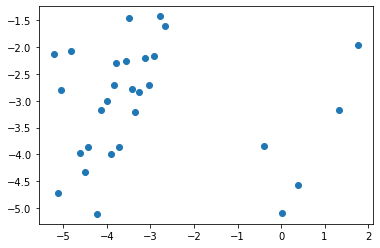

In [19]:
plt.scatter(est,real)

### task 1

In [22]:
stats.spearmanr(est_sub1,real_sub1)

SpearmanrResult(correlation=0.36125956676089727, pvalue=0.09855830214401948)

In [19]:
1 - spatial.distance.cosine(est_sub1,real_sub1)

0.0403516482952857

In [20]:
np.corrcoef(est_sub1,real_sub1)

array([[1.        , 0.02294597],
       [0.02294597, 1.        ]])

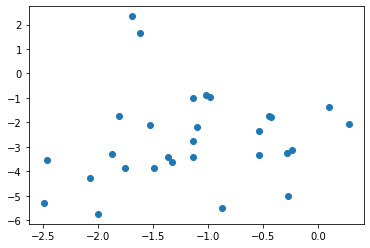

In [22]:
plt.scatter(est_sub1,real_sub1)

### task 2

In [23]:
stats.spearmanr(est_sub2,real_sub2)

SpearmanrResult(correlation=0.9439448931993434, pvalue=4.3818619802175125e-11)

In [24]:
1 - spatial.distance.cosine(est_sub2,real_sub2)

0.6905724290271665

In [25]:
np.corrcoef(est_sub2,real_sub2)

array([[1.        , 0.67145035],
       [0.67145035, 1.        ]])

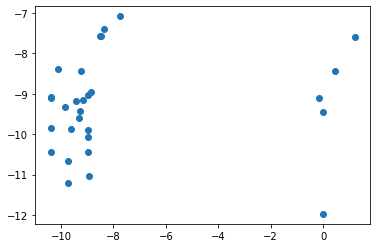

In [23]:
plt.scatter(est_sub2,real_sub2)

### task 3

In [24]:
stats.spearmanr(est_sub3,real_sub3)

SpearmanrResult(correlation=0.9609325037548205, pvalue=1.2719320469082497e-12)

In [28]:
1 - spatial.distance.cosine(est_sub3,real_sub3)

0.9582296238510127

In [29]:
np.corrcoef(est_sub3,real_sub3)

array([[1.        , 0.77240937],
       [0.77240937, 1.        ]])

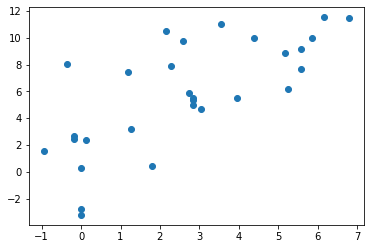

In [24]:
plt.scatter(est_sub3,real_sub3)

# task 4 & 5

In [25]:
stats.spearmanr(est_sub4,real_sub4)

SpearmanrResult(correlation=0.6047589357749842, pvalue=0.0028680126673700785)

In [26]:
stats.spearmanr(est_sub5,real_sub5)

SpearmanrResult(correlation=0.30025475293225057, pvalue=0.17456332380409073)

In [29]:
stats.spearmanr(est_sub6,real_sub6)

SpearmanrResult(correlation=0.6889144679384945, pvalue=0.0003916752010604538)

# Flops of Top5

In [10]:
# layout_idx = [45,0,50,37,49,2,9] # NYUv2 resnet top-5
# layout_idx = [7,11,10,9,8,0,2] # NYUv2 mobilenet top-5
# layout_idx = [353,352,958,480,360,1037,962,1046,943,1063,479,817,562,4697,6539,1,0,4] # Taskonomy resnet top-5
# layout_idx = [651,2947,3221,3215,3220,3261,0,4] # Taskonomy mobilenet top-5
layout_idx = [7]

In [6]:
if model == 'resnet':
    prototxt = 'models/deeplab_resnet34_adashare.prototxt'
    coarse_B = 5
    mapping = {0:[0], 1:[1,2,3], 2:[4,5,6,7], 3:[8,9,10,11,12,13], 4:[14,15,16], 5:[17]}
elif model == 'mobilenet':
    prototxt = 'models/mobilenetv2.prototxt'
#     coarse_B = 9
#     mapping = {0:[0], 1:[1,2], 2:[3,4,5,6], 3:[7,8,9,10,11], 4:[12,13,14,15,16,17], 5:[18,19,20,21,22], 
#            6:[23,24,25,26,27], 7:[28,29,30], 8:[31], 9:[32]} 
#     coarse_B = 6
#     mapping = {0:[0], 1:[1,2,3,4,5,6], 2:[7,8,9,10,11], 3:[12,13,14,15,16,17], 4:[18,19,20,21,22,23,24,25,26,27], 5:[28,29,30,31], 6:[32]}
    coarse_B = 5
    mapping = {0:[0,1,2,3,4,5,6], 1:[7,8,9,10,11,12,13,14,15,16,17], 2:[18,19,20,21,22], 
           3:[23,24,25,26,27,28,29,30], 4:[31], 5:[32]}

In [7]:
if data == 'NYUv2':
    cls_num = {'segment_semantic': 40, 'normal':3, 'depth_zbuffer': 1}
    input_dim = (3,321,321)
elif data == 'Taskonomy':
    cls_num = {'segment_semantic': 17, 'normal': 3, 'depth_zbuffer': 1, 'keypoints2d': 1, 'edge_texture': 1}
    input_dim = (3,224,224)

In [8]:
with torch.no_grad():
    backbone = MTSeqBackbone(prototxt)
    fined_B = len(backbone.basic_blocks)
    feature_dim = backbone(torch.rand((1,)+input_dim)).shape[1]

In [11]:
for idx in layout_idx:
    layout = coarse_to_fined(layout_list[idx], fined_B, mapping)
    with torch.no_grad():
        model = MTSeqModel(prototxt, layout=layout, feature_dim=feature_dim, cls_num=cls_num, verbose=False)
        macs, params = get_model_complexity_info(model, input_dim, as_strings=True,
                                               print_per_layer_stat=False, verbose=False)
        print('Layout idx: '+str(idx))
        print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        print('{:<30}  {:<8}'.format('Parameters: ', params))
        print('='*80)
        break

Layout idx: 7
Computational complexity:       20.11 GMac
Parameters:                     158.79 M


## top-k under flops

In [16]:
K = 5
flops = 171.39 # Taskonomy, resnet
count = 0
for i in range(0,len(layout_order)):
    if count >= K:
        break
    L = coarse_to_fined(layout_list[layout_order[i]], fined_B, mapping)
    with torch.no_grad():
        model = MTSeqModel(prototxt, layout=L, feature_dim=feature_dim, cls_num=cls_num, verbose=False)
        macs, params = get_model_complexity_info(model, input_dim, as_strings=True,
                                               print_per_layer_stat=False, verbose=False)
    if float(macs[:-5]) <= flops:
        print(layout_order[i])
        print(layout_list[layout_order[i]])
        print(layout_list[layout_order[i]].score)
        print(macs)
        print('=' * 100)
        
        count += 1

958
[[{1, 2, 4}, {0, 3}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {2}, {1}], [{0, 3}, {4}, {2}, {1}]]
2.1406691092673733
169.47 GMac
480
[[{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{0}, {3}, {1, 2, 4}], [{0}, {3}, {2, 4}, {1}], [{0}, {3}, {2, 4}, {1}]]
2.1089931778379
168.75 GMac
360
[[{1, 2, 3, 4}, {0}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {2}, {1}], [{0}, {3, 4}, {2}, {1}]]
2.045923858933043
169.47 GMac
1037
[[{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{0, 3}, {2, 4}, {1}], [{0, 3}, {2, 4}, {1}]]
1.9554496973706585
151.03 GMac
962
[[{1, 2, 4}, {0, 3}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {2}, {1}]]
1.8953368092111829
163.73 GMac
